偵測到電腦核心數 = 16
522729 OD pairs
723 zones
10132 nodes
25370 links
Reading the network data took 4.2 secs
==== 開始交通指派 ====
Iteration 1 no improvement in gap: inf count: 1
    Iteration 1 completed :)


C:\Users\Allen\AppData\Local\Temp\ipykernel_13024\1982321822.py:190: RuntimeWarning: invalid value encountered in power
  tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
c:\Users\Allen\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 2 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 3 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 4 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 5 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 6 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 7 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 8 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 9 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 10 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 11 no improvement in gap: 0.02817 count: 1
    Iteration 11 completed :)
Iteration 12 no improvement in gap: 0.02848 count: 2
    Iteration 12 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 13 no improvement in gap: 0.02246 count: 3
    Iteration 13 completed :)
    Iteration 14 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 15 no improvement in gap: 0.03769 count: 1
    Iteration 15 completed :)
Iter

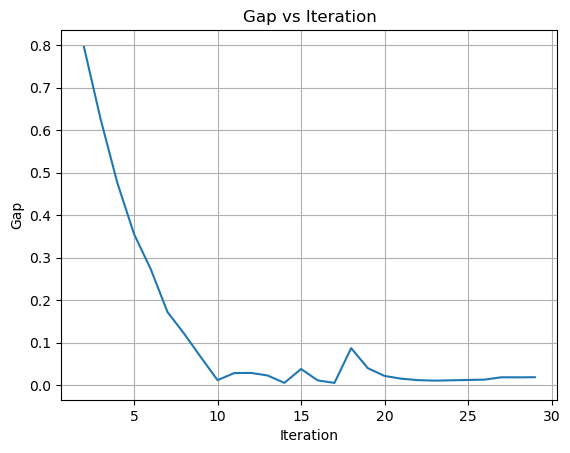

----------找到 min_gap iteration =  17 。重新開始指派-----------
==== 開始交通指派 ====
Iteration 1 no improvement in gap: inf count: 1
    Iteration 1 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 2 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 3 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 4 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 5 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 6 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 7 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 8 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 9 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 10 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 11 no improvement in gap: 0.02817 count: 1
    Iteration 11 completed :)
Iteration 12 no improvement in gap: 0.02848 count: 2
    Iteration 12 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 13 no improvement in gap: 0.02246 count: 3
    Iteration 13 completed :

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 21:09:46 2017 (modified for performance)
Author: Pramesh Kumar (original)
        Modified by ChatGPT (2025-04-15)

效能改進措施：
 1. 平行化 AON 分配（loadAON_parallel）
 2. 程式內部部分小幅向量化與簡化（例如 updateTravelTime）
 3. 後續可考慮用 numba 進行 JIT 加速（目前未做大幅調整）
"""

import math
import time
import heapq
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
import copy
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

inputLocation = "Taipei/"

# 動態偵測可用 CPU 核心數
import os
CPU_COUNT = os.cpu_count() or 1
print(f"偵測到電腦核心數 = {CPU_COUNT}")

# -------------------------------
# 基本資料結構與初始化
# -------------------------------
class Zone:
    def __init__(self, _tmpIn):
        self.zoneId = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.destList = []


class Node:
    '''
    此類別儲存網絡中節點的資訊
    '''
    def __init__(self, _tmpIn):
        self.Id = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.outLinks = []
        self.inLinks = []
        self.label = float("inf")
        self.pred = ""
        self.inDegree = 0
        self.outDegree = 0
        self.order = 0  # 拓樸排序順序
        self.wi = 0.0  # Dial 演算法中節點權重
        self.xi = 0.0  # Dial 演算法中節點流量
        self.xj = 0.0  # 新增：用於流量回溯時累計需求


class Link:
    '''
    此類別儲存網絡中連結的資訊
    '''
    def __init__(self, _tmpIn):
        self.tailNode = _tmpIn[0]
        self.headNode = _tmpIn[1]
        self.capacity = float(_tmpIn[2])  # veh per hour
        self.length = float(_tmpIn[3])      # Length
        self.fft = float(_tmpIn[4])         # Free flow travel time (min)
        self.beta = float(_tmpIn[6])
        self.alpha = float(_tmpIn[5])
        self.speedLimit = float(_tmpIn[7])
        #self.toll = float(_tmpIn[9])
        #self.linkType = float(_tmpIn[10])
        self.flow = 0.0
        self.cost = float(_tmpIn[4])
        self.logLike = 0.0
        self.reasonable = True  # 用於 Dial 隨機分配
        self.wij = 0.0  # Dial 演算法中連結權重
        self.xij = 0.0  # Dial 演算法中該連結上流量累計


class Demand:
    def __init__(self, _tmpIn):
        self.fromZone = _tmpIn[0]
        self.toNode = _tmpIn[1]
        self.demand = float(_tmpIn[2])


def readDemand():
    inFile = open(inputLocation + "demand.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        tripSet[tmpIn[0], tmpIn[1]] = Demand(tmpIn)
        if tmpIn[0] not in zoneSet:
            zoneSet[tmpIn[0]] = Zone([tmpIn[0]])
        if tmpIn[1] not in zoneSet:
            zoneSet[tmpIn[1]] = Zone([tmpIn[1]])
        if tmpIn[1] not in zoneSet[tmpIn[0]].destList:
            zoneSet[tmpIn[0]].destList.append(tmpIn[1])
    inFile.close()
    print(len(tripSet), "OD pairs")
    print(len(zoneSet), "zones")


def readNetwork():
    inFile = open(inputLocation + "network.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        linkSet[tmpIn[0], tmpIn[1]] = Link(tmpIn)
        if tmpIn[0] not in nodeSet:
            nodeSet[tmpIn[0]] = Node(tmpIn[0])
        if tmpIn[1] not in nodeSet:
            nodeSet[tmpIn[1]] = Node(tmpIn[1])
        if tmpIn[1] not in nodeSet[tmpIn[0]].outLinks:
            nodeSet[tmpIn[0]].outLinks.append(tmpIn[1])
        if tmpIn[0] not in nodeSet[tmpIn[1]].inLinks:
            nodeSet[tmpIn[1]].inLinks.append(tmpIn[0])
    inFile.close()
    print(len(nodeSet), "nodes")
    print(len(linkSet), "links")


# -------------------------------
# 初始讀取
# -------------------------------
readStart = time.time()

tripSet = {}
zoneSet = {}
linkSet = {}
nodeSet = {}

readDemand()
readNetwork()

originZones = set([k[0] for k in tripSet])
print("Reading the network data took", round(time.time() - readStart, 2), "secs")

# -------------------------------
# Dijkstra 及相關函數（原始版本改為局部版本）
# -------------------------------
def DijkstraHeap(origin):
    """
    計算從 origin 到所有節點的最短路徑，
    直接更新 global nodeSet（用於 deterministic loading）
    """
    for n in nodeSet:
        nodeSet[n].label = float("inf")
        nodeSet[n].pred = ""
    nodeSet[origin].label = 0.0
    nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = nodeSet[currentNode].label
        for toNode in nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = nodeSet[newNode].label
            newLabel = currentLabel + linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                nodeSet[newNode].label = newLabel
                nodeSet[newNode].pred = newPred


def updateTravelTime():
    """
    更新連結的 travel time，使用 BPR 公式
    """
    for l in linkSet:
        ratio = linkSet[l].flow / linkSet[l].capacity
        linkSet[l].cost = linkSet[l].fft * (1 + linkSet[l].alpha * (ratio ** linkSet[l].beta))


def findAlpha(x_bar):
    """
    使用非約束最佳化找出 Frank-Wolfe 演算法中的步長，
    如果 fsolve 失敗，則使用 fallback 固定步長
    """
    def df(alpha):
        sum_derivative = 0
        for l in linkSet:
            tmpFlow = linkSet[l].flow + alpha * (x_bar[l] - linkSet[l].flow)
            tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
            sum_derivative += (x_bar[l] - linkSet[l].flow) * tmpCost
        return sum_derivative
    sol = optimize.root(df, np.array([0.1]))
    sol2 = fsolve(df, np.array([0.1]))
    if not sol.success or not (0 < sol2[0] <= 1):
        print("fsolve 無法找到有效步長，改用 fallback 步長")
        return 0.2
    return max(0.1, min(1, sol2[0]))


def tracePreds(dest):
    """
    回溯獲取從起點至 dest 的最短路徑
    """
    prevNode = nodeSet[dest].pred
    spLinks = []
    visited = set()
    while nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        spLinks.append((prevNode, dest))
        if prevNode == "":
            print(f"警告：節點 {dest} 的 pred 是空字串")
            break
        dest = prevNode
        prevNode = nodeSet[dest].pred
    return spLinks



def loadAON():
    """
    傳統 All-or-Nothing 分配：針對每個原點執行 Dijkstra，
    並根據最短路徑分配需求，回傳總的 SPTT 與輔助流量 x_bar
    """
    x_bar = {l: 0.0 for l in linkSet}
    SPTT = 0.0
    for r in originZones:
        DijkstraHeap(r)
        for s in zoneSet[r].destList:
            try:
                dem = tripSet[r, s].demand
            except KeyError:
                dem = 0.0
            SPTT += nodeSet[s].label * dem
            if r != s:
                for spLink in tracePreds(s):
                    x_bar[spLink] += dem
    return SPTT, x_bar


# -------------------------------
# 平行化 All-or-Nothing 分配（Performance Improvement）
# -------------------------------
def DijkstraHeap_local(origin, local_nodeSet, local_linkSet):
    """
    局部版本的 Dijkstra，操作拷貝後的資料
    """
    for n in local_nodeSet:
        local_nodeSet[n].label = float("inf")
        local_nodeSet[n].pred = ""
    local_nodeSet[origin].label = 0.0
    local_nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = local_nodeSet[currentNode].label
        for toNode in local_nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = local_nodeSet[newNode].label
            newLabel = currentLabel + local_linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                local_nodeSet[newNode].label = newLabel
                local_nodeSet[newNode].pred = newPred


def tracePreds_local(dest, local_nodeSet):
    """
    局部版本的回溯函數，用於平行運算中
    """
    spLinks = []
    visited = set()
    while local_nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"Local 循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        pred = local_nodeSet[dest].pred
        spLinks.append((pred, dest))
        if pred == "":
            print(f"Local 警告：節點 {dest} 的 pred 是空字串")
            break
        dest = pred
    return spLinks


def compute_aon_for_origin(origin):
    """
    針對單一原點，利用深複製後的資料計算 AON 分配，
    回傳該原點的最短路徑總旅行時間（SPTT）與局部輔助流量字典
    """
    local_nodeSet = copy.deepcopy(nodeSet)
    local_linkSet = copy.deepcopy(linkSet)
    DijkstraHeap_local(origin, local_nodeSet, local_linkSet)
    local_SPTT = 0.0
    local_x_bar = {l: 0.0 for l in local_linkSet}
    for s in zoneSet[origin].destList:
        try:
            dem = tripSet[origin, s].demand
        except KeyError:
            dem = 0.0
        local_SPTT += local_nodeSet[s].label * dem
        if origin != s:
            spLinks = tracePreds_local(s, local_nodeSet)
            for link in spLinks:
                local_x_bar[link] += dem
    return local_SPTT, local_x_bar


def loadAON_parallel():
    """
    平行化版本的 All-or-Nothing 分配：
    將所有原點的 AON 分配平行計算後合併結果
    """
    global_origins = list(originZones)
    total_SPTT = 0.0
    total_x_bar = {l: 0.0 for l in linkSet}
    with ProcessPoolExecutor(max_workers= {CPU_COUNT}) as executor:
        futures = {executor.submit(compute_aon_for_origin, r): r for r in global_origins}
        for future in as_completed(futures):
            try:
                sptt, x_bar_partial = future.result()
                total_SPTT += sptt
                for l in x_bar_partial:
                    total_x_bar[l] += x_bar_partial[l]
            except Exception as exc:
                print(f"Origin {futures[future]} 發生例外: {exc}")
    return total_SPTT, total_x_bar


# -------------------------------
# Dial 演算法及交通指派
# -------------------------------
def findReasonableLinks():
    for l in linkSet:
        if nodeSet[l[1]].label > nodeSet[l[0]].label:
            linkSet[l].reasonable = True
        else:
            linkSet[l].reasonable = False


def computeLogLikelihood():
    for l in linkSet:
        if linkSet[l].reasonable:
            linkSet[l].logLike = math.exp(nodeSet[l[1]].label - nodeSet[l[0]].label - linkSet[l].cost)


def topologicalOrdering():
    for e in linkSet:
        if linkSet[e].reasonable:
            nodeSet[e[1]].inDegree += 1
    order = 0
    SEL = [k for k in nodeSet if nodeSet[k].inDegree == 0]
    while SEL:
        i = SEL.pop(0)
        order += 1
        nodeSet[i].order = order
        for j in nodeSet[i].outLinks:
            if linkSet[i, j].reasonable:
                nodeSet[j].inDegree -= 1
                if nodeSet[j].inDegree == 0:
                    SEL.append(j)
    if order < len(nodeSet):
        print("the network has cycle(s)")


def resetDialAttributes():
    for n in nodeSet:
        nodeSet[n].inDegree = 0
        nodeSet[n].outDegree = 0
        nodeSet[n].order = 0
        nodeSet[n].wi = 0.0
        nodeSet[n].xi = 0.0
        nodeSet[n].xj = 0.0
    for l in linkSet:
        linkSet[l].logLike = 0.0
        linkSet[l].reasonable = True
        linkSet[l].wij = 0.0
        linkSet[l].xij = 0.0


def DialLoad():
    """
    使用 Dial 演算法進行 stochastic loading
    """
    resetDialAttributes()
    x_bar = {l: 0.0 for l in linkSet}
    for r in originZones:
        DijkstraHeap(r)
        findReasonableLinks()
        topologicalOrdering()
        computeLogLikelihood()

        # 正向傳播：計算節點權重
        order = 1
        while order <= len(nodeSet):
            i = [k for k in nodeSet if nodeSet[k].order == order][0]
            if order == 1:
                nodeSet[i].wi = 1.0
            else:
                nodeSet[i].wi = sum([linkSet[k, i].wij for k in nodeSet[i].inLinks if linkSet[k, i].reasonable])
            for j in nodeSet[i].outLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].wij = nodeSet[i].wi * linkSet[i, j].logLike
            order += 1

        # 逆向回溯：分配流量
        order = len(nodeSet)
        while order >= 1:
            j = [k for k in nodeSet if nodeSet[k].order == order][0]
            try:
                dem = tripSet[r, j].demand
            except KeyError:
                dem = 0.0
            nodeSet[j].xj = dem + sum([linkSet[j, k].xij for k in nodeSet[j].outLinks if linkSet[j, k].reasonable])
            for i in nodeSet[j].inLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].xij = nodeSet[j].xj * (linkSet[i, j].wij / nodeSet[j].wi)
            order -= 1
        for l in linkSet:
            if linkSet[l].reasonable:
                x_bar[l] += linkSet[l].xij
    return x_bar

def assignment(loading, algorithm, accuracy, maxIter, allow, recal, parallel_loading=False):
    """
    執行交通指派：
      - loading: "deterministic" 或 "stochastic"
      - algorithm: "MSA" 或 "FW"
      - parallel_loading: 若 True 則使用平行化 deterministic loading
    """
    mingap = False
    it = 1
    count = 0
    current_min_gap = float("inf")
    gap = float("inf")
    x_bar = {l: 0.0 for l in linkSet}
    startP = time.time()
    gap_lst = []


    print("==== 開始交通指派 ====")
    while gap > accuracy:
        if algorithm == "MSA" or it < 2:
            alpha = 1.0 / it
        elif algorithm == "FW":
            alpha = findAlpha(x_bar)
        else:
            print("Terminating the program.....")
            print("The solution algorithm", algorithm, "does not exist!")
        prevLinkFlow = np.array([linkSet[l].flow for l in linkSet])
        for l in linkSet:
            linkSet[l].flow = alpha * x_bar[l] + (1 - alpha) * linkSet[l].flow
        updateTravelTime()
        if loading == "deterministic":
            SPTT, x_bar = loadAON()  # 或 loadAON_parallel() 根據需求選用
            TSTT = round(sum([linkSet[a].flow * linkSet[a].cost for a in linkSet]), 3)
            SPTT = round(SPTT, 3)
            if SPTT == 0:
                print("警告：SPTT 為 0，無法計算收斂 gap。將 gap 設為 0。")
                gap = 0
            else:
                gap = round(abs((TSTT / SPTT) - 1), 5)
            if it == 1:
                gap = gap + float("inf")
        elif loading == "stochastic":
            x_bar = DialLoad()
            currentLinkFlow = np.array([linkSet[l].flow for l in linkSet])
            change = prevLinkFlow - currentLinkFlow
            if it < 3:
                gap = gap + float("inf")
            else:
                gap = round(np.linalg.norm(np.divide(change, prevLinkFlow, out=np.zeros_like(change), where=prevLinkFlow != 0)), 2)
        else:
            print("Terminating the program.....")
            print("The loading", loading, "is unknown")
        
        gap_lst.append(gap)


        # save the current smallest gap
        if gap < current_min_gap:
            current_min_gap = gap
            min_gap_it = it
            count = 0

        elif gap >= current_min_gap:
            # if more than 10 iterations without improvement, stop the assignment
            if count > allow:
                print("The assignment did not converge: no improvement in", allow, "iterations, current gap:", gap)
                mingap = True
                break
            count += 1
            print("Iteration", it, "no improvement in gap:", gap, "count:", count)
        
        if it >= maxIter:
            print("The assignment did not converge: max iterations reached, current gap:", gap)
            break

        print(f"    Iteration {it} completed :)")

        it += 1

    print("Assignment took", time.time() - startP, "seconds")
    print("Assignment stopped in", it, "iterations, current gap:", gap)
    #from gap_lst find the minimum gap and its iteration
    min_gap = min(gap_lst)
    min_gap_it = gap_lst.index(min_gap) + 1 # +1 because iteration starts from 1
    print("Minimum gap found at iteration", min_gap_it, "with gap", min_gap)

    if recal == False:
        #plot gap_lst
        plt.plot(range(1, len(gap_lst) + 1), gap_lst)
        plt.xlabel("Iteration")
        plt.ylabel("Gap")
        plt.title("Gap vs Iteration")
        plt.grid()
        plt.savefig("gap_vs_iteration.png")
        plt.show()

    return min_gap_it, mingap
    

def writeUEresults():
    outFile = open("UE_results.dat", "w")
    tmpOut = "tailNode\theadNode\tcapacity\tlength\tfft\tUE_travelTime\tUE_flow"
    outFile.write(tmpOut + "\n")
    for i in linkSet:
        tmpOut = f"{linkSet[i].tailNode}\t{linkSet[i].headNode}\t{linkSet[i].capacity}\t{linkSet[i].length}\t{linkSet[i].fft}\t{linkSet[i].cost}\t{linkSet[i].flow}"
        outFile.write(tmpOut + "\n")
    outFile.close()

# -------------------------------
# 健康檢查：輸出網絡狀態
# -------------------------------
def checkNetworkHealth():
    print("==== Network Health Check ====")
    isolated = [n for n in nodeSet if len(nodeSet[n].inLinks) == 0 and len(nodeSet[n].outLinks) == 0]
    print(f"完全孤立節點: {len(isolated)}")
    unreachable = [node for node in nodeSet if nodeSet[node].pred == ""]
    print(f"目前未標定 predecessor 的節點數: {len(unreachable)}")
    allFlowZero = all(linkSet[l].flow == 0.0 for l in linkSet)
    print("所有流量皆為 0？", allFlowZero)


# -------------------------------
#三個可調整參數：accuracy, maxIter, allow(繼續迭代幾次 gap沒有改善就停)
# -------------------------------
min_gap_it, mingap = assignment("deterministic", "FW", accuracy = 0.001, maxIter = 100, allow = 10, recal=False, parallel_loading=True)


if mingap == True: #已知最佳迭代次數，進行二次指派
    print("----------找到 min_gap iteration = ", min_gap_it,"。重新開始指派-----------")
    assignment("deterministic", "FW", accuracy=0.00001, maxIter=min_gap_it, allow=10000, recal=True, parallel_loading=True)
writeUEresults()
checkNetworkHealth()

In [3]:
import pandas as pd

#open 校估.xlsx
#for sheet 1: link, AM, PM, A, B
#it stands for link name, AM flow, PM flow, A node, B node
#for sheet 2: link, AM, PM, A1, B1, A2, B2
#it stands for link name, AM flow, PM flow, A1 node, B1 node, A2 node, B2 node

#open UE_results.dat
#use (A, B) as key to find the corresponding link name in 校估.xlsx and compare AM flow with UE_flow

df= pd.read_excel("校估.xlsx", sheet_name=None)
sheet1 = df["工作表1"]
sheet2 = df["工作表2"]

ue_results = pd.read_csv("UE_results.dat", sep="\t")
ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)

ue_results["link_name"] = ue_results.apply(lambda row: f"{int(row['A'])}_{int(row['B'])}", axis=1)
sheet1["link_name"] = sheet1.apply(lambda row: f"{row['A']}_{row['B']}", axis=1)

#look up UE_flow in ue_results to add a new column to sheet1 and sheet2
sheet1 = sheet1.merge(ue_results[["link_name", "UE_flow", "capacity"]], on="link_name", how="left")
#reserve the link,AM,UE_flow
sheet1 = sheet1[["link", "AM", "UE_flow", "capacity"]]
#calculate the difference percentage
sheet1["diff"] = (-sheet1["AM"] + sheet1["UE_flow"]) / sheet1["AM"] * 100
sheet1["diff"] = sheet1["diff"].round(2)
sheet1["diff"] = sheet1["diff"].astype(str) + "%"

#for sheet2, we need to find the corresponding link name for A1, B1 and A2, B2
#that is, there are two link to be found for each row in sheet2
#then we need to add up the two link's UE_flow to get the total flow for this row
#so that we can compare with AM flow
sheet2["link_name1"] = sheet2.apply(lambda row: f"{int(row['A1'])}_{int(row['B1'])}", axis=1)
sheet2["link_name2"] = sheet2.apply(lambda row: f"{int(row['A2'])}_{int(row['B2'])}", axis=1)
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name1", right_on="link_name", how="left")
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name2", right_on="link_name", how="left", suffixes=('_1', '_2'))
#calculate the total flow and capacity for this row
sheet2["UE_flow"] = sheet2["UE_flow_1"] + sheet2["UE_flow_2"]
sheet2["capacity"] = sheet2["capacity_1"] + sheet2["capacity_2"]
#calculate the difference percentage
sheet2["diff"] = (-sheet2["AM"] + sheet2["UE_flow"]) / sheet2["AM"] * 100
sheet2["diff"] = sheet2["diff"].round(2)
sheet2["diff"] = sheet2["diff"].astype(str) + "%"
#reserve the link,AM,UE_flow
sheet2 = sheet2[["link", "AM", "UE_flow", "capacity", "diff"]]

#now,we can combine the two sheets
sheet1 = pd.concat([sheet1, sheet2], ignore_index=True)

#calculate the mape for the whole data from diff
sheet1["diff_abs"] = sheet1["diff"].str.replace("%", "").astype(float).abs()
#V/C ratio = UE_flow / capacity
sheet1["V/C"] = sheet1["UE_flow"] / sheet1["capacity"]
#GEH = (2(UE_flow - AM)^2 / (UE_flow + AM))^0.5
sheet1["GEH"] = (2 * (sheet1["UE_flow"] - sheet1["AM"]) ** 2 / (sheet1["UE_flow"] + sheet1["AM"])) ** 0.5
#average the diff_abs and print the result
mape = sheet1["diff_abs"].mean()
#round the UE_flow, V/C and capacity to int
sheet1["capacity"] = sheet1["capacity"].astype(int)
# sheet1["capacity"] = sheet1["capacity"].round(0).astype(int)
sheet1["UE_flow"] = sheet1["UE_flow"].round(0).astype(int)
sheet1["V/C"] = sheet1["V/C"].round(2)
print("MAPE: ", mape.round(2), "%")

#in sheet1, if link contains "橋進城" or "橋出城", then it is a bridge link
bridge_in = sheet1[sheet1["link"].str.contains("橋進城")]
bridge_out = sheet1[sheet1["link"].str.contains("橋出城")]
#in sheet1, if link contains "南" or "北", then it is a arterial link
arterial_south = sheet1[sheet1["link"].str.contains("南")]
arterial_north = sheet1[sheet1["link"].str.contains("北")]
#in sheet1, if link contains "東" or "西", then it is a arterial link
arterial_east = sheet1[sheet1["link"].str.contains("東")]
arterial_west = sheet1[sheet1["link"].str.contains("西")]

#calculate total AM and UE_flow for bridge_in and bridge_out, so that we can know the error percentage
bridge_in_total = bridge_in["AM"].sum()
bridge_out_total = bridge_out["AM"].sum()
bridge_in_ue_total = bridge_in["UE_flow"].sum()
bridge_out_ue_total = bridge_out["UE_flow"].sum()
bridge_in_diff = (bridge_in_ue_total - bridge_in_total) / bridge_in_total * 100
bridge_out_diff = (bridge_out_ue_total - bridge_out_total) / bridge_out_total * 100
print("聯外橋樑進城 AM flow: ", bridge_in_total, "UE flow: ", bridge_in_ue_total, "diff: ", bridge_in_diff.round(2), "%")
print("聯外橋樑出城 AM flow: ", bridge_out_total, "UE flow: ", bridge_out_ue_total, "diff: ", bridge_out_diff.round(2), "%")
#calculate total AM and UE_flow for arterial_south and arterial_north, so that we can know the error percentage
arterial_south_total = arterial_south["AM"].sum()
arterial_north_total = arterial_north["AM"].sum()
arterial_south_ue_total = arterial_south["UE_flow"].sum()
arterial_north_ue_total = arterial_north["UE_flow"].sum()
arterial_south_diff = (arterial_south_ue_total - arterial_south_total) / arterial_south_total * 100
arterial_north_diff = (arterial_north_ue_total - arterial_north_total) / arterial_north_total * 100
print("南向主幹道 AM flow: ", arterial_south_total, "UE flow: ", arterial_south_ue_total, "diff: ", arterial_south_diff.round(2), "%")
print("北向主幹道 AM flow: ", arterial_north_total, "UE flow: ", arterial_north_ue_total, "diff: ", arterial_north_diff.round(2), "%")
#calculate total AM and UE_flow for arterial_east and arterial_west, so that we can know the error percentage
arterial_east_total = arterial_east["AM"].sum()
arterial_west_total = arterial_west["AM"].sum()
arterial_east_ue_total = arterial_east["UE_flow"].sum()
arterial_west_ue_total = arterial_west["UE_flow"].sum()
arterial_east_diff = (arterial_east_ue_total - arterial_east_total) / arterial_east_total * 100
arterial_west_diff = (arterial_west_ue_total - arterial_west_total) / arterial_west_total * 100
print("東向主幹道 AM flow: ", arterial_east_total, "UE flow: ", arterial_east_ue_total, "diff: ", arterial_east_diff.round(2), "%")
print("西向主幹道 AM flow: ", arterial_west_total, "UE flow: ", arterial_west_ue_total, "diff: ", arterial_west_diff.round(2), "%")

#screenline 1: 百齡橋,新生高,中山橋,大直橋
#screenline 2: 重陽橋,臺北橋,忠孝橋,中興橋


#we can conduct a simple statistical analysis to see if the distribution of the flow is different
import scipy.stats as stats
#compare the distribution of the flow between AM and UE_flow for 南北向主幹道、東西向主幹道
def ks_test(am_flow, ue_flow):
    #use ks test to compare the distribution
    ks_statistic, p_value = stats.ks_2samp(am_flow, ue_flow)
    print("KS test statistic: ", ks_statistic)
    print("p-value: ", p_value)
    if p_value < 0.05:
        print("拒絕虛無假設：AM flow 與 UE flow 的分佈不同")
    else:
        print("接受虛無假設：AM flow 與 UE flow 的分佈相同")
#南向主幹道
south_arterial = sheet1[sheet1["link"].str.contains("南")]
am_flow = south_arterial["AM"].values
ue_flow = south_arterial["UE_flow"].values
#use ks test to compare the distribution
print("南向主幹道：")
ks_test(am_flow, ue_flow)
#北向主幹道
north_arterial = sheet1[sheet1["link"].str.contains("北")]
am_flow = north_arterial["AM"].values
ue_flow = north_arterial["UE_flow"].values
#use ks test to compare the distribution
print("北向主幹道：")
ks_test(am_flow, ue_flow)
#東向主幹道
east_arterial = sheet1[sheet1["link"].str.contains("東")]
am_flow = east_arterial["AM"].values
ue_flow = east_arterial["UE_flow"].values
#use ks test to compare the distribution
print("東向主幹道：")
ks_test(am_flow, ue_flow)
#西向主幹道
west_arterial = sheet1[sheet1["link"].str.contains("西")]
am_flow = west_arterial["AM"].values
ue_flow = west_arterial["UE_flow"].values
#use ks test to compare the distribution
print("西向主幹道：")
ks_test(am_flow, ue_flow)
#compare the distribution of the flow between AM and UE_flow for 聯外橋樑
#聯外橋樑進城
bridge_in = sheet1[sheet1["link"].str.contains("橋進城")]
am_flow = bridge_in["AM"].values
ue_flow = bridge_in["UE_flow"].values
#use ks test to compare the distribution
print("聯外橋樑進城：")
ks_test(am_flow, ue_flow)
#聯外橋樑出城
bridge_out = sheet1[sheet1["link"].str.contains("橋出城")]
am_flow = bridge_out["AM"].values
ue_flow = bridge_out["UE_flow"].values
#use ks test to compare the distribution
print("聯外橋樑出城：")
ks_test(am_flow, ue_flow)


sheet1[["link", "capacity", "AM", "UE_flow", "V/C", "diff", "GEH"]]

MAPE:  33.43 %
聯外橋樑進城 AM flow:  38955 UE flow:  38379 diff:  -1.48 %
聯外橋樑出城 AM flow:  22556 UE flow:  26475 diff:  17.37 %
南向主幹道 AM flow:  28285 UE flow:  23039 diff:  -18.55 %
北向主幹道 AM flow:  73957 UE flow:  57021 diff:  -22.9 %
東向主幹道 AM flow:  19166 UE flow:  9118 diff:  -52.43 %
西向主幹道 AM flow:  7921 UE flow:  5502 diff:  -30.54 %
南向主幹道：
KS test statistic:  0.3076923076923077
p-value:  0.5881960656115993
接受虛無假設：AM flow 與 UE flow 的分佈相同
北向主幹道：
KS test statistic:  0.2647058823529412
p-value:  0.1859197921823477
接受虛無假設：AM flow 與 UE flow 的分佈相同
東向主幹道：
KS test statistic:  0.8333333333333334
p-value:  0.025974025974025972
拒絕虛無假設：AM flow 與 UE flow 的分佈不同
西向主幹道：
KS test statistic:  0.6666666666666666
p-value:  0.14285714285714285
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑進城：
KS test statistic:  0.2857142857142857
p-value:  0.9627039627039629
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑出城：
KS test statistic:  0.2857142857142857
p-value:  0.9627039627039629
接受虛無假設：AM flow 與 UE flow 的分佈相同


,link,capacity,AM,UE_flow,V/C,diff,GEH
0,民權路進城(關渡站前),6980,6326,5567,0.80,-12.0%,9.840005
1,民權路出城(關渡站前),6980,4236,4247,0.61,0.25%,0.164640
2,關渡橋進城,3332,3568,3824,1.15,7.18%,4.213131
3,關渡橋出城,3332,3654,3966,1.19,8.53%,5.050830
4,百齡橋進城,9800,7299,7748,0.79,6.15%,5.171435
5,百齡橋出城,9800,5284,9363,0.96,77.2%,47.667868
6,大直橋進城,6980,2623,3824,0.55,45.77%,21.147684
7,大直橋出城,6980,3503,2989,0.43,-14.68%,9.027773
8,承德入城(劍潭路),3920,2053,3273,0.83,59.41%,23.634881
9,承德離城(劍潭路),3920,1383,3485,0.89,152.0%,42.608888


MAPE:  35.28 %
聯外橋樑進城 AM flow:  29033 UE flow:  30667 diff:  5.63 %
聯外橋樑出城 AM flow:  13769 UE flow:  17099 diff:  24.18 %
南向主幹道 AM flow:  20085 UE flow:  19978 diff:  -0.53 %
北向主幹道 AM flow:  33085 UE flow:  33083 diff:  -0.01 %
南向主幹道：
KS test statistic:  0.2222222222222222
p-value:  0.9894693541752365
接受虛無假設：AM flow 與 UE flow 的分佈相同
北向主幹道：
KS test statistic:  0.1875
p-value:  0.9522562797299043
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑進城：
KS test statistic:  0.2
p-value:  1.0
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑出城：
KS test statistic:  0.4
p-value:  0.873015873015873
接受虛無假設：AM flow 與 UE flow 的分佈相同


MAPE:  32.3 %
聯外橋樑進城 AM flow:  29033 UE flow:  28547 diff:  -1.67 %
聯外橋樑出城 AM flow:  13769 UE flow:  15711 diff:  14.1 %
南向主幹道 AM flow:  20085 UE flow:  16996 diff:  -15.38 %
北向主幹道 AM flow:  33085 UE flow:  30076 diff:  -9.09 %
南向主幹道：
KS test statistic:  0.3333333333333333
p-value:  0.7301110654051831
接受虛無假設：AM flow 與 UE flow 的分佈相同
北向主幹道：
KS test statistic:  0.1875
p-value:  0.9522562797299043
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑進城：
KS test statistic:  0.4
p-value:  0.873015873015873
接受虛無假設：AM flow 與 UE flow 的分佈相同
聯外橋樑出城：
KS test statistic:  0.4
p-value:  0.873015873015873
接受虛無假設：AM flow 與 UE flow 的分佈相同

1.3
MAPE:  31.88 %
聯外橋樑進城 AM flow:  29033 UE flow:  28140 diff:  -3.08 %
聯外橋樑出城 AM flow:  13769 UE flow:  15291 diff:  11.05 %
南向主幹道 AM flow:  20085 UE flow:  19083 diff:  -4.99 %
北向主幹道 AM flow:  33085 UE flow:  31196 diff:  -5.71 %

In [23]:
import geopandas as gpd
import pandas as pd

ue_results = pd.read_csv("UE_results.dat", sep="\t")
gdf = gpd.read_file("Y110_modified_v6.shp")

# Rename columns to match
ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)

# Merge results back into the shapefile
gdf = gdf.merge(ue_results[["A", "B", "capacity", "UE_travelTime", "UE_flow"]], on=["A", "B"], how="left")

# Calculate V/C ratio
gdf["V/C"] = gdf["UE_flow"] / gdf["capacity"]
# Calculate assigned speed
gdf["assigned_speed"] = gdf["LENGTH"] / gdf["UE_travelTime"] * 60 #km/min->km/h

# Save updated shapefile
gdf.to_file("UE_results_v7.shp")

C:\Users\Allen\AppData\Local\Temp\ipykernel_12604\4245104760.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("UE_results_v7.shp")
c:\Users\Allen\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
c:\Users\Allen\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'assigned_speed' to 'assigned_s'
  ogr_write(
